# Scraping

In [3]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pickle
import os
import sys
import warnings
import time

from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--disable-images")  # Disable images
edge_options.add_argument("--disable-javascript")  # Disable JavaScript
edge_options.add_argument("--disable-plugins")  # Disable plugins
edge_options.add_argument("--disable-extensions")  # Disable extensions
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Another image disabling flag


# Set a minimal User-Agent (like a text-only browser)
edge_options.add_argument("user-agent=Links (2.25; Linux 2.4.24)")

driver = webdriver.Edge(options=edge_options)
#driver.execute_cdp_cmd("Network.setBlockedURLs", {"urls": ["*.jpg", "*.png", "*.gif","*.svg"]})
#driver.execute_cdp_cmd("Network.enable", {})


driver.maximize_window()

driver.execute_script("document.body.style.zoom='67%'")

url='https://www.kaggle.com/rankings?group=datasets'
driver.get(url)

In [ ]:
all_users = []
count_previous = 0
count_same = 0
total_scrolls = 0

while True:
    scroll_element = driver.find_element(By.CSS_SELECTOR, 'div[role="presentation"][class="MuiDataGrid-virtualScroller css-1pzb349"]')
    href_elements = scroll_element.find_elements(By.CSS_SELECTOR, 'div[class="MuiDataGrid-row"] div[class="sc-bSficL fIzKan"] a[class="sc-ehIYnC jNnqAS"]')

    for href_element in href_elements:
        try:
            href = href_element.get_attribute('href')
            all_users.append(href)

        except:
            continue

    all_users = list(set(all_users))  # Remove duplicates

    if len(all_users) == count_previous:
        count_same += 1
    else:
        count_same = 0

    if count_same >= 3:
        break

    count_previous = len(all_users)
    
    total_scrolls += 1

    driver.execute_script("arguments[0].scrollBy(0, 700);", scroll_element)
    time.sleep(2)

    print(f'{len(all_users)}, {total_scrolls}, {count_same}', end='\r')  # Updated print line to avoid repeated overwriting


In [ ]:
pickle.dump(all_users, open('all_users.pikcle','wb'))

In [ ]:
all_users=pickle.load( open('all_users.pikcle','rb'))

In [ ]:
all_data=[]

for i, user_url in enumerate(all_users,start=1):
    driver.get(user_url)
    time.sleep(1)

    try:
        name_user_name=driver.find_element(By.CSS_SELECTOR,'div[class="sc-iwoKJl oqUoq"] div[style="margin-bottom: 32px;"]').text
    except:
        name_user_name=None

    try:
        info=driver.find_element(By.CSS_SELECTOR,'ul[class="sc-dTVHQl dJyLvc"]').text
    except:
        info=None

    try:
        rank=[i for i in driver.find_elements(By.CSS_SELECTOR,'div[class="sc-hSDYTR bHLckj"]') if 'Datasets' in i.text][0].find_element(By.CSS_SELECTOR,'div[class="sc-gsiZRa gsbkrV"]').text
    except:
        rank=None

    try:
        followers=[i.text for i in driver.find_elements(By.CSS_SELECTOR,'div[class="sc-fyvmDH lmFuud"]') if 'Followers' in i.text]
    except:
        followers=None

    try:
        following=[i.text for i in driver.find_elements(By.CSS_SELECTOR,'div[class="sc-fyvmDH lmFuud"]') if 'Following' in i.text]
    except:
        following=None

    dict={'URL':user_url,'Name And Username':name_user_name, 'Inof':info, 'Rank':rank,'Followers':followers, 'Following':following}
    all_data.append(dict)

    print(f'Progress : {i}/{len(all_users)}, {dict}',end='\r')



In [ ]:
driver.quit()

# Cleaning

In [ ]:
pickle.dump(all_data, open('all_data_datasets.pickle','wb'))

In [4]:
all_data=pickle.load( open('all_data_datasets.pickle','rb'))

In [5]:
df=pd.DataFrame(all_data)

In [6]:
df.isna().sum()

URL                   0
Name And Username    47
Inof                 45
Rank                 71
Followers             0
Following             0
dtype: int64

In [7]:
df=df.rename(columns={'Inof':'Info'})

In [8]:
df['Country']=df['Info'].apply(lambda x:x.split('pin_drop\n')[-1].split('\n')[0].split(',')[-1].strip() if isinstance(x,str) and 'pin_drop' in str(x) else None)

df['Member For']=df['Info'].str.split('Joined').str[-1].str.split('ago').str[0].str.strip()

In [9]:
df['Rank']=df['Rank'].str.split('\nof').str[0].str.replace(',','').apply(pd.to_numeric)

In [10]:
df['Followers']=df['Followers'].apply(lambda x:x[0].split('(')[-1].split(')')[0] if isinstance(x,list) and len(x)>=1 else 0).apply(pd.to_numeric)
df['Following']=df['Following'].apply(lambda x:x[0].split('(')[-1].split(')')[0] if isinstance(x,list) and len(x)>=1 else 0).apply(pd.to_numeric)

In [11]:
df=df[['URL','Rank','Country','Followers','Following']]
df=df.dropna(subset='Rank').reset_index(drop=True)

In [12]:
df['URL']=df['URL'].apply(lambda x:x.split('/')[-1])
df=df.rename(columns={'URL':'User'})

In [13]:
df=df.sort_values('Rank')
df['Rank']=df['Rank'].astype(int)

In [14]:
df.to_csv('rankings.csv',index=False)

# EDA

In [15]:
grouped=df.groupby('Country')['User'].count().sort_values(ascending=False)
grouped.head(20)

Country
India                   979
United States           247
Pakistan                164
Egypt                   114
Bangladesh               77
Iran                     60
United Kingdom           58
Germany                  47
Canada                   46
Turkey                   46
Russia                   46
Brazil                   46
Japan                    41
Türkiye                  37
Spain                    30
France                   28
Australia                24
South Korea              24
China                    24
United Arab Emirates     22
Name: User, dtype: int64

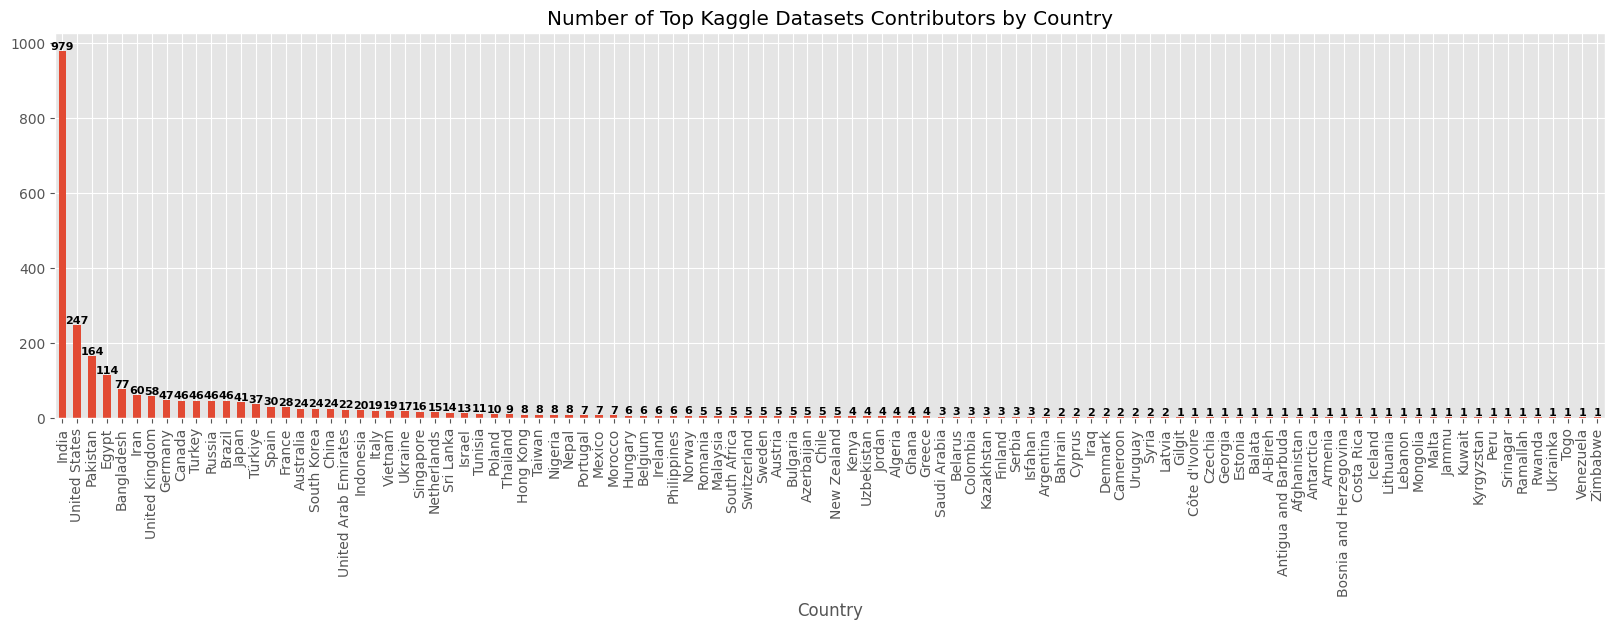

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

ax=grouped.plot.bar(figsize=(20,5),fontsize=10,title='Number of Top Kaggle Datasets Contributors by Country')
for i in range(len(grouped)):
    ax.text(i, grouped.values[i]+5,grouped.values[i], fontweight='bold',size=8,ha='center')

plt.show()